In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import jieba
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from tensorflow.keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

2022-01-07 10:42:30.835600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-07 10:42:30.835770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.version.VERSION)

2.7.0


# Import data

In [3]:
df = pd.read_csv('./data/merged.csv')
df = df[['Singer', 'Name', 'Lyric', 'Category']].astype(str)
df.drop(df[df.Singer == 'nan'].index, inplace=True)
df.drop(df[df.Name == 'Name'].index, inplace=True)
print("\033[32mTotal number of data: %d\033[0m" %len(df))
df

Total number of data: 2206


,Singer,Name,Lyric,Category
0,A-Lin,One Life,白雲撞進藍天 激起昨天畫面我想起你的臉好久不見 在遠方的My Friend不論晴天雨天 也會...,友情
1,A-Lin,最好的朋友在身邊,一起笑一起哭一起鬧久別的回憶又浮現一點點一天天一年年最好的朋友在身邊一起走一起跑一起跳相聚到...,友情
2,A-Lin,愛的可能,你出現我身邊 像個奇蹟發生沒想到會是你 讓我如此失魂我心中的感覺是這樣陌生快樂的牽掛在相聚的...,友情
3,A-Lin,太太太耐斯,孩子還沒睡 拜託別鬧手遊聲太吵 狗狗在叫碗盤在洗碗槽 主婦的煩惱惱公不瞭 他先洗澡奶瓶把香水...,反抗反駁反諷
4,A-Lin,抱歉 我不抱歉,恨 什麼叫恨 這個單字 好陌生我只記得 一路走來 愛的人就算他們 多可恨等 雖然溫柔 還打不...,反抗反駁反諷
...,...,...,...,...
2202,陳奕迅,黑暗中漫舞,為何未能學會起舞便已抱緊你誰料到資質不配合你左腳舉起了便要別離為何未能讓我衰老便要放開你陪你...,離別
2203,陳奕迅,傷信,重讀著你的告別信 抑壓了暗湧雖不信寫的話 竟可以這麼重但再哭亦無用 徐徐又當這信是你 緊貼我...,離別
2204,陳奕迅,歲月如歌,愛上了 看見你 如何不懂謙卑去講心中理想 不會俗氣猶如看得見晨曦 才能歡天喜地抱著你 我每次...,離別
2205,陳奕迅,遇見了你(國),遇見了你 讓生命美好我看見繁華的春天愛情如陽光閃耀我給你我的愛離開了我 你默默低頭我看見往事...,離別


In [4]:
d = {'Category': df['Category'].value_counts().index, 'count': df['Category'].value_counts()}
df_cat = pd.DataFrame(data = d).reset_index(drop = True)
df_cat

,Category,count
0,愛情,874
1,想法表達,405
2,悲傷,216
3,反抗反駁反諷,206
4,勵志,167
5,嗨歌,125
6,離別,76
7,友情,42
8,特殊主題,39
9,親情,33


In [5]:
df.loc[df.Category == '勵志','Category'] = '勵志友情'
df.loc[df.Category == '友情','Category'] = '勵志友情'
df.loc[df.Category == '悲傷','Category'] = '悲傷離別'
df.loc[df.Category == '離別','Category'] = '悲傷離別'
df.loc[df.Category == '特殊主題','Category'] = '其他'
df.loc[df.Category == '嗨歌','Category'] = '其他'
df.loc[df.Category == '親情','Category'] = '其他'
df.loc[df.Category == '感謝','Category'] = '想法表達'
df

,Singer,Name,Lyric,Category
0,A-Lin,One Life,白雲撞進藍天 激起昨天畫面我想起你的臉好久不見 在遠方的My Friend不論晴天雨天 也會...,勵志友情
1,A-Lin,最好的朋友在身邊,一起笑一起哭一起鬧久別的回憶又浮現一點點一天天一年年最好的朋友在身邊一起走一起跑一起跳相聚到...,勵志友情
2,A-Lin,愛的可能,你出現我身邊 像個奇蹟發生沒想到會是你 讓我如此失魂我心中的感覺是這樣陌生快樂的牽掛在相聚的...,勵志友情
3,A-Lin,太太太耐斯,孩子還沒睡 拜託別鬧手遊聲太吵 狗狗在叫碗盤在洗碗槽 主婦的煩惱惱公不瞭 他先洗澡奶瓶把香水...,反抗反駁反諷
4,A-Lin,抱歉 我不抱歉,恨 什麼叫恨 這個單字 好陌生我只記得 一路走來 愛的人就算他們 多可恨等 雖然溫柔 還打不...,反抗反駁反諷
...,...,...,...,...
2202,陳奕迅,黑暗中漫舞,為何未能學會起舞便已抱緊你誰料到資質不配合你左腳舉起了便要別離為何未能讓我衰老便要放開你陪你...,悲傷離別
2203,陳奕迅,傷信,重讀著你的告別信 抑壓了暗湧雖不信寫的話 竟可以這麼重但再哭亦無用 徐徐又當這信是你 緊貼我...,悲傷離別
2204,陳奕迅,歲月如歌,愛上了 看見你 如何不懂謙卑去講心中理想 不會俗氣猶如看得見晨曦 才能歡天喜地抱著你 我每次...,悲傷離別
2205,陳奕迅,遇見了你(國),遇見了你 讓生命美好我看見繁華的春天愛情如陽光閃耀我給你我的愛離開了我 你默默低頭我看見往事...,悲傷離別


In [6]:
d = {'Category': df['Category'].value_counts().index, 'count': df['Category'].value_counts()}
df_cat = pd.DataFrame(data = d).reset_index(drop = True)
df_cat

,Category,count
0,愛情,874
1,想法表達,428
2,悲傷離別,292
3,勵志友情,209
4,反抗反駁反諷,206
5,其他,197


# Preprocessing

In [7]:
condition = df['Category'] == '愛情'
df_select = df[condition].sample(200)
condition = df['Category'] == '想法表達'
df_tmp = df[condition].sample(0)
df_select = pd.concat([df_select, df_tmp])
condition = df['Category'] == '勵志友情'
df_tmp = df[condition].sample(200)
df_select = pd.concat([df_select, df_tmp])
condition = df['Category'] == '悲傷離別'
df_tmp = df[condition].sample(200)
df_select = pd.concat([df_select, df_tmp])
condition = df['Category'] == '反抗反駁反諷'
df_tmp = df[condition].sample(200)
df_select = pd.concat([df_select, df_tmp])

df_select = df_select.reset_index(drop=True)

In [8]:
categories = list(df_select['Category'].value_counts().index)
cat_to_id = dict(zip(categories, range(len(categories))))
def label_to_id(line):
    line = str(line)
    return cat_to_id[line]

In [9]:
def remove_punctuation(line):
    stopwords = [line.strip() for line in open('./data/stopwords.txt', 'r', encoding='utf-8').readlines()]
    line = str(line)
    if line.strip() == '':
        return ''
    re_han = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = re_han.sub('', line)
    cut = [w for w in list(jieba.cut(line)) if w not in stopwords]
    res = ", ".join(cut)
    return res

In [10]:
def count_words(line):
    line_list = line.split(', ')
    return len(line_list)

In [11]:
df_select['y'] = df_select['Category'].apply(label_to_id)
df_select['seg_text'] = df_select['Lyric'].apply(remove_punctuation)
df_select['word_num'] = df_select['seg_text'].apply(count_words)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.181 seconds.
Prefix dict has been built successfully.


In [12]:
df_select

,Singer,Name,Lyric,Category,y,seg_text,word_num
0,蔡依林,熱冬(Hot Winter),HOT HOT HOT HOT氣候暖化我的心卻在冬眠桃花少到比北極熊還可憐周末夜沒有半通手機...,愛情,0,"HOTHOTHOTHOT, 氣候, 暖化, 心, 卻, 冬眠, 桃花, 少到, 比北極, 熊...",110
1,林宥嘉,成全,看著你和她走到我面前微笑地對我說聲好久不見如果當初沒有我的成全是不是今天還在原地盤旋不為了勉...,愛情,0,"看著, 走, 面前, 微笑, 說, 聲, 好久, 不見, 當初, 成全, 是不是, 今天, ...",135
2,張惠妹,不在乎他,親愛的他 早就不願 困在這個地方逃避負擔吧 誰也不願作回答我不得不想 他的身影不停回答告訴自...,愛情,0,"親愛的, 早就, 不願困, 地方, 逃避, 負擔, 不願作, 回答, 想, 身影, 不停, ...",75
3,陳奕迅,快高長大,天空太高 早餐太早你未投訴 我代你憤怒溫心的雪糕 溫室的野草你未及提到 我已經捧到 長期被愛...,愛情,0,"天空, 太高, 早餐, 太早, 未, 投訴, 我代, 憤怒, 溫心, 雪糕, 溫室, 野草,...",82
4,梁靜茹,我都知道,愛上你不受侷限 原來我心裡也有某些狂野就像擺脫了一切 兩個人光腳奔跑在曠野我錯過 我瞭解 跳...,愛情,0,"愛上, 受, 侷, 限, 原來, 我心, 裡也, 狂野, 擺脫, 兩個, 人光腳, 奔跑, ...",79
...,...,...,...,...,...,...,...
795,張惠妹,到底,你幹嘛不敢坦白坦白的說你喜歡喜歡刷存在感喜歡狂野姿態但就是不肯鬆口說你想要怎麼辦我不想要再等...,反抗反駁反諷,3,"幹, 不敢, 坦白, 坦白, 說, 喜歡, 喜歡, 刷, 存在, 感喜歡, 狂野, 姿態, ...",146
796,陳奕迅,兄妹,對我好 對我好 好到無路可退可是我也很想 有個人陪才不願把你得罪 於是那麼迂迴一時進 一時退...,反抗反駁反諷,3,"好, 好好, 無路, 可退, 想, 人, 陪, 不願, 得罪, 迂, 迴, 一時, 進一時,...",68
797,SHE,心還是熱的,Woo wo woo Woo wo woo 浪漫地相信過 委屈地懷疑過我面對 自我被愛情跋...,反抗反駁反諷,3,"WoowowooWoowowoo, 浪漫, 相信, 委屈, 地懷, 疑過, 我面, 自我, ...",107
798,SHE,別,我把思念輕輕上鎖 再把回憶掛在門口 離開就不回頭昨天已經放在左手 明天裝箱全部帶走 今天我只...,反抗反駁反諷,3,"思念, 輕輕, 上鎖, 再, 回憶掛, 門口, 離開, 回頭, 昨天, 已經, 放在, 左手...",56


In [13]:
df_select["word_num"].mean()

108.78625

In [14]:
d = {'Category': df_select['Category'].value_counts().index, 'count': df_select['Category'].value_counts()}
df_cat = pd.DataFrame(data = d).reset_index(drop = True)
df_cat

,Category,count
0,愛情,200
1,勵志友情,200
2,悲傷離別,200
3,反抗反駁反諷,200


# Get train / val / test

In [15]:
from gensim.models.doc2vec import TaggedDocument
import collections

In [16]:
from sklearn.utils import shuffle

np.random.seed(1234)

df = shuffle(df_select)
df.reset_index(drop = True, inplace = True)
df

,Singer,Name,Lyric,Category,y,seg_text,word_num
0,陳奕迅,MY GIRL,不只是因為相信妳的眼光 才找妳陪我挑選沙發和床不只是因為感謝你幫我忙 才不累不煩送你接你上班...,愛情,0,"相信, 妳, 眼光, 找, 妳, 陪, 挑選沙, 發和床, 感謝, 幫, 忙, 不累, 不煩...",107
1,張惠妹,日出,BA LA BA LA BA LA BONBA LA BA LA BON...當那太陽升起的...,愛情,0,"BALABALABALABONBALABALABON, 當那太陽, 升起, 唱, 隻, 歌,...",100
2,陳奕迅,阿牛,不能回頭 多年前早明言不能回頭可恨在是我這一頭蠻牛幾年來無法侍候 才和我分手成婚之前一刻才趕...,反抗反駁反諷,3,"回頭, 多年, 前早, 明言, 回頭, 可恨, 這一頭, 牛, 幾年, 無法, 侍候, 分手...",131
3,A-Lin,狂風裡擁抱(信+A-Lin),屬于我們那種幸福 別人不會懂就是走過太多苦澀 能牽手才感動無論再苦 你也只是 眺望著天空怕我...,愛情,0,"屬于, 那種, 幸福, 懂, 走過, 太多苦, 澀, 牽手, 感動, 再, 苦, 眺望, 天...",142
4,蘇打綠,我好想你,開了燈 眼前的模樣偌大的房 寂寞的床關了燈 全都一個樣心裡的傷 無法分享生命 隨年月流去 隨...,悲傷離別,2,"開, 燈, 眼前, 模樣, 偌大, 房, 寂寞, 床關, 燈, 一個樣, 心裡, 傷無法, ...",112
...,...,...,...,...,...,...,...
795,蘇打綠,一千座噴泉,"有一千座噴泉同在一座小鎮裡頭迷路人們常旋轉在重覆街道路口I said, wow, wow, ...",勵志友情,1,"一千, 座, 噴泉同, 一座, 小鎮裡頭, 迷路, 人們, 常旋轉, 重覆, 街道, 路口,...",51
796,A-Lin,一直走,浪花做的啤酒海溫柔做的沙好白 (hi)不穿鞋子的腳踝快樂能信手拈來 (shine)跟著我 ...,勵志友情,1,"浪花, 做, 啤酒, 海溫, 柔, 做, 沙好, hi, 穿, 鞋子, 腳踝, 快樂能, 信...",145
797,林俊傑,不死之身,陽光放棄這最後一秒讓世界被黑暗籠罩懲罰著人們的驕傲我忍受寒冷的煎熬和北風狂妄的咆哮對命運做抵...,愛情,0,"陽光, 放棄, 這最, 後, 一秒, 世界, 黑暗, 籠罩, 懲罰, 著人們, 驕傲, 忍受...",61
798,五月天,將軍令,在等誰 一聲下令以後才想起 呼吸你的自由從何時 習慣這種生活 Oh ～不相信 或是相信什麼其...,勵志友情,1,"一聲, 下令, 以後才, 想起, 呼吸, 自由, 從何, 時, 習慣, 這種, 生活, Oh...",139


In [17]:
# 分割訓練集和測試集
train, test = train_test_split(df, test_size = 0.2, random_state = 27, stratify = df.Category.values)
train, val = train_test_split(train, test_size = 0.125, random_state = 27, stratify = train.Category.values)

In [18]:
# 對標籤進行編碼
train_y = train.y
val_y = val.y
test_y = test.y
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1, 1)
val_y = le.transform(val_y).reshape(-1, 1)
test_y = le.transform(test_y).reshape(-1, 1)

# 將標籤編碼轉成onehot
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

In [19]:
## 使用Tokenizer對詞組進行編碼，編號是根據詞頻，詞頻越大，編號越小
max_words = 7000
max_len = 120
tok = Tokenizer(num_words = max_words)  ## 使用的最大词语数为5000
tok.fit_on_texts(train.seg_text)

In [20]:
# 將數據轉換成序列
train_seq = tok.texts_to_sequences(train.seg_text)
val_seq = tok.texts_to_sequences(val.seg_text)
test_seq = tok.texts_to_sequences(test.seg_text)
# 將序列調整為一樣長度 (padding)
train_seq_mat = sequence.pad_sequences(train_seq, maxlen = max_len)
val_seq_mat = sequence.pad_sequences(val_seq, maxlen = max_len)
test_seq_mat = sequence.pad_sequences(test_seq, maxlen = max_len)

print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(560, 120)
(80, 120)
(160, 120)


# Build Model

## Define Attention Layer

In [21]:
from tensorflow.python.keras.layers import Layer
from keras import backend as K

In [22]:
class AttentionLayer(Layer):
    def __init__(self, attention_size=None, **kwargs):
        self.attention_size = attention_size
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config['attention_size'] = self.attention_size
        return config
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.time_steps = input_shape[1]
        hidden_size = input_shape[2]
        if self.attention_size is None:
            self.attention_size = hidden_size
            
        self.W = self.add_weight(name='att_weight', shape=(hidden_size, self.attention_size),
                                initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        self.V = self.add_weight(name='att_var', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        self.V = K.reshape(self.V, (-1, 1))
        H = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.softmax(K.dot(H, self.V), axis=1)
        outputs = K.sum(score * inputs, axis=1)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

## Define Model

In [23]:
## 定義Bi-LSTM+Attention模型
inputs = Input(name = 'inputs',shape = [max_len])
## Embedding(詞彙表大小, batch size, 歌詞長度)
layer = Embedding(max_words + 1, 128, input_length=max_len)(inputs)
layer = Bidirectional(LSTM(128, dropout = 0.2, return_sequences=True), merge_mode = 'concat')(layer)
layer = AttentionLayer(attention_size = 128)(layer)
layer = Dense(128, activation = "relu", name = "FC1")(layer)
layer = Dropout(0.4)(layer)
layer = Dense(len(categories), activation = "softmax", name = "FC2")(layer)
model_BiLSTM_Att = Model(inputs = inputs, outputs = layer)

2022-01-07 10:42:47.853981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-07 10:42:47.854120: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-07 10:42:47.854187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (67-0459790-H1): /proc/driver/nvidia/version does not exist
2022-01-07 10:42:47.854580: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
## 定義Bi-LSTM模型
inputs = Input(name = 'inputs',shape = [max_len])
## Embedding(詞彙表大小, batch size, 歌詞長度)
layer = Embedding(max_words + 1, 128, input_length=max_len)(inputs)
layer = Bidirectional(LSTM(128, dropout = 0.2), merge_mode = 'concat')(layer)
layer = Dense(128, activation = "relu", name = "FC1")(layer)
layer = Dropout(0.4)(layer)
layer = Dense(len(categories), activation = "softmax", name = "FC2")(layer)
model_BiLSTM = Model(inputs = inputs, outputs = layer)

In [25]:
## 定義LSTM+Attention模型
inputs = Input(name = 'inputs',shape = [max_len])
## Embedding(詞彙表大小, batch size, 歌詞長度)
layer = Embedding(max_words + 1, 128, input_length=max_len)(inputs)
layer = LSTM(128, dropout = 0.2, return_sequences=True)(layer)
layer = AttentionLayer(attention_size = 128)(layer)
layer = Dense(128, activation = "relu", name = "FC1")(layer)
layer = Dropout(0.4)(layer)
layer = Dense(len(categories), activation = "softmax", name = "FC2")(layer)
model_LSTM_Att = Model(inputs = inputs, outputs = layer)

In [26]:
## 定義LSTM模型
inputs = Input(name = 'inputs',shape = [max_len])
## Embedding(詞彙表大小, batch size, 歌詞長度)
layer = Embedding(max_words + 1, 128, input_length=max_len)(inputs)
layer = LSTM(128, dropout = 0.2)(layer)
layer = Dense(128, activation = "relu", name = "FC1")(layer)
layer = Dropout(0.4)(layer)
layer = Dense(len(categories), activation = "softmax", name = "FC2")(layer)
model_LSTM = Model(inputs = inputs, outputs = layer)

In [27]:
# optimizer = optimizers.RMSprop(lr = 0.0001, decay = 1e-6)
optimizer = optimizers.Adam(lr = 0.0001, decay = 1e-6)
model_BiLSTM_Att.compile(loss = "categorical_crossentropy", optimizer = optimizer ,metrics = ["accuracy"])
model_BiLSTM.compile(loss = "categorical_crossentropy", optimizer = optimizer ,metrics = ["accuracy"])
model_LSTM_Att.compile(loss = "categorical_crossentropy", optimizer = optimizer ,metrics = ["accuracy"])
model_LSTM.compile(loss = "categorical_crossentropy", optimizer = optimizer ,metrics = ["accuracy"])

/home/vivian/miniconda3/envs/tf2/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
model_BiLSTM_Att_history = model_BiLSTM_Att.fit(train_seq_mat, train_y, batch_size = 8, epochs = 10, 
                                                validation_data = (val_seq_mat, val_y))

Epoch 1/10
70/70 [==============================] - 16s 165ms/step - loss: 1.3854 - accuracy: 0.2625 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 2/10
70/70 [==============================] - 10s 139ms/step - loss: 1.3834 - accuracy: 0.3357 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 3/10
70/70 [==============================] - 12s 165ms/step - loss: 1.3782 - accuracy: 0.3982 - val_loss: 1.3867 - val_accuracy: 0.2375
Epoch 4/10
70/70 [==============================] - 10s 143ms/step - loss: 1.3653 - accuracy: 0.4429 - val_loss: 1.3864 - val_accuracy: 0.2375
Epoch 5/10
70/70 [==============================] - 13s 187ms/step - loss: 1.1705 - accuracy: 0.4821 - val_loss: 1.4913 - val_accuracy: 0.3375
Epoch 6/10
70/70 [==============================] - 17s 237ms/step - loss: 0.8258 - accuracy: 0.6446 - val_loss: 1.8861 - val_accuracy: 0.3500
Epoch 7/10
70/70 [==============================] - 11s 159ms/step - loss: 0.5693 - accuracy: 0.7482 - val_loss: 1.6898 - val_accuracy: 0.3125

In [29]:
model_BiLSTM_history = model_BiLSTM.fit(train_seq_mat, train_y, batch_size = 8, epochs = 10, 
                                                validation_data = (val_seq_mat, val_y))

Epoch 1/10
70/70 [==============================] - 15s 157ms/step - loss: 1.3871 - accuracy: 0.2500 - val_loss: 1.3835 - val_accuracy: 0.3125
Epoch 2/10
70/70 [==============================] - 9s 136ms/step - loss: 1.3659 - accuracy: 0.3964 - val_loss: 1.3621 - val_accuracy: 0.2875
Epoch 3/10
70/70 [==============================] - 10s 139ms/step - loss: 1.1907 - accuracy: 0.5250 - val_loss: 1.3272 - val_accuracy: 0.3250
Epoch 4/10
70/70 [==============================] - 10s 141ms/step - loss: 0.9048 - accuracy: 0.5607 - val_loss: 1.3581 - val_accuracy: 0.3125
Epoch 5/10
70/70 [==============================] - 10s 147ms/step - loss: 0.6625 - accuracy: 0.7179 - val_loss: 1.5558 - val_accuracy: 0.3625
Epoch 6/10
70/70 [==============================] - 9s 125ms/step - loss: 0.5325 - accuracy: 0.8357 - val_loss: 1.8970 - val_accuracy: 0.3375
Epoch 7/10
70/70 [==============================] - 9s 125ms/step - loss: 0.3833 - accuracy: 0.8839 - val_loss: 1.8692 - val_accuracy: 0.3625
Ep

In [30]:
model_LSTM_Att_history = model_LSTM_Att.fit(train_seq_mat, train_y, batch_size = 8, epochs = 10, 
                                                validation_data = (val_seq_mat, val_y))

Epoch 1/10
70/70 [==============================] - 9s 98ms/step - loss: 1.3844 - accuracy: 0.2768 - val_loss: 1.3874 - val_accuracy: 0.2500
Epoch 2/10
70/70 [==============================] - 7s 94ms/step - loss: 1.3708 - accuracy: 0.3661 - val_loss: 1.3845 - val_accuracy: 0.2750
Epoch 3/10
70/70 [==============================] - 9s 122ms/step - loss: 1.2789 - accuracy: 0.4518 - val_loss: 1.3333 - val_accuracy: 0.3875
Epoch 4/10
70/70 [==============================] - 9s 129ms/step - loss: 1.0111 - accuracy: 0.5250 - val_loss: 1.4151 - val_accuracy: 0.2875
Epoch 5/10
70/70 [==============================] - 7s 102ms/step - loss: 0.8810 - accuracy: 0.5446 - val_loss: 1.5907 - val_accuracy: 0.2750
Epoch 6/10
70/70 [==============================] - 7s 103ms/step - loss: 0.8366 - accuracy: 0.5714 - val_loss: 1.4004 - val_accuracy: 0.4625
Epoch 7/10
70/70 [==============================] - 7s 105ms/step - loss: 0.7170 - accuracy: 0.6089 - val_loss: 1.4129 - val_accuracy: 0.4500
Epoch 8/

In [31]:
model_LSTM_history = model_LSTM.fit(train_seq_mat, train_y, batch_size = 8, epochs = 10, 
                                                validation_data = (val_seq_mat, val_y))

Epoch 1/10
70/70 [==============================] - 13s 136ms/step - loss: 1.3866 - accuracy: 0.2143 - val_loss: 1.3838 - val_accuracy: 0.3625
Epoch 2/10
70/70 [==============================] - 8s 119ms/step - loss: 1.3412 - accuracy: 0.5357 - val_loss: 1.4163 - val_accuracy: 0.2500
Epoch 3/10
70/70 [==============================] - 8s 120ms/step - loss: 1.0689 - accuracy: 0.5857 - val_loss: 1.4698 - val_accuracy: 0.3375
Epoch 4/10
70/70 [==============================] - 8s 114ms/step - loss: 0.7707 - accuracy: 0.6946 - val_loss: 1.3709 - val_accuracy: 0.3375
Epoch 5/10
70/70 [==============================] - 8s 115ms/step - loss: 0.5298 - accuracy: 0.8143 - val_loss: 1.6263 - val_accuracy: 0.3625
Epoch 6/10
70/70 [==============================] - 9s 124ms/step - loss: 0.3435 - accuracy: 0.9161 - val_loss: 1.7955 - val_accuracy: 0.3375
Epoch 7/10
70/70 [==============================] - 9s 123ms/step - loss: 0.1569 - accuracy: 0.9786 - val_loss: 1.6930 - val_accuracy: 0.3625
Epoch

In [32]:
# model_BiLSTM_Att.save('./model/model_BiLSTM_Att.h5')
# model_BiLSTM.save('./model/model_BiLSTM.h5')
# model_LSTM_Att.save('./model/model_LSTM_Att.h5')
# model_LSTM.save('./model/model_LSTM.h5')

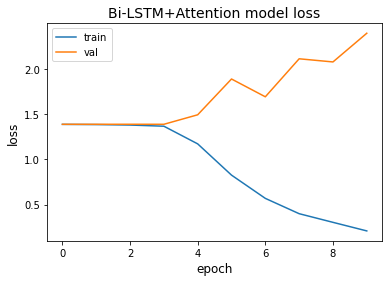

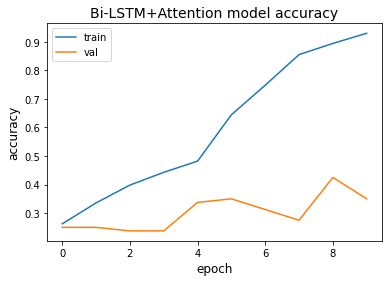

In [33]:
from matplotlib import pyplot as plt
plt.plot(model_BiLSTM_Att_history.history['loss'])
plt.plot(model_BiLSTM_Att_history.history['val_loss'])
plt.title('Bi-LSTM+Attention model loss', size = 14)
plt.ylabel('loss', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model_BiLSTM_Att_history.history['accuracy'])
plt.plot(model_BiLSTM_Att_history.history['val_accuracy'])
plt.title('Bi-LSTM+Attention model accuracy', size = 14)
plt.ylabel('accuracy', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

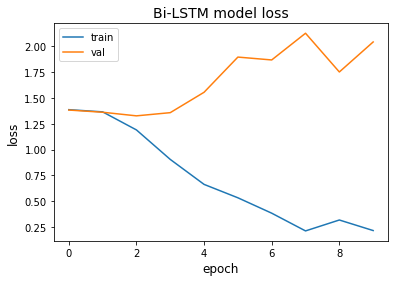

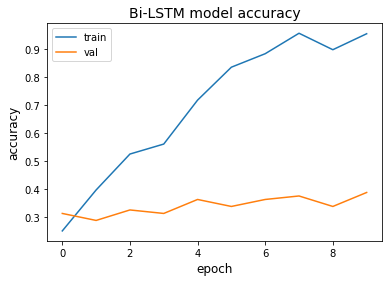

In [34]:
from matplotlib import pyplot as plt
plt.plot(model_BiLSTM_history.history['loss'])
plt.plot(model_BiLSTM_history.history['val_loss'])
plt.title('Bi-LSTM model loss', size = 14)
plt.ylabel('loss', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model_BiLSTM_history.history['accuracy'])
plt.plot(model_BiLSTM_history.history['val_accuracy'])
plt.title('Bi-LSTM model accuracy', size = 14)
plt.ylabel('accuracy', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

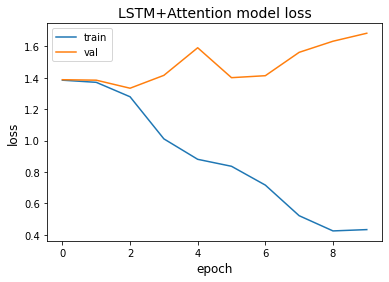

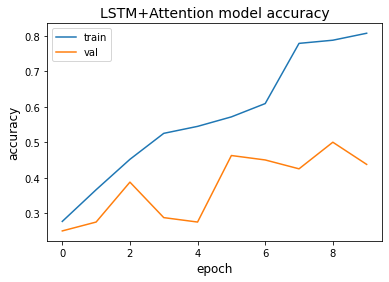

In [35]:
from matplotlib import pyplot as plt
plt.plot(model_LSTM_Att_history.history['loss'])
plt.plot(model_LSTM_Att_history.history['val_loss'])
plt.title('LSTM+Attention model loss', size = 14)
plt.ylabel('loss', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model_LSTM_Att_history.history['accuracy'])
plt.plot(model_LSTM_Att_history.history['val_accuracy'])
plt.title('LSTM+Attention model accuracy', size = 14)
plt.ylabel('accuracy', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

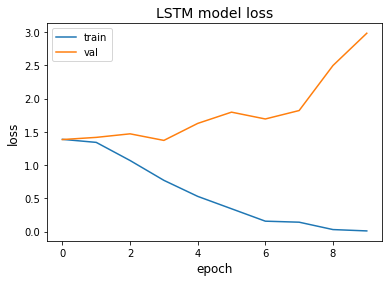

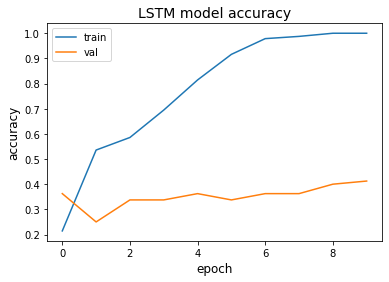

In [36]:
from matplotlib import pyplot as plt
plt.plot(model_LSTM_history.history['loss'])
plt.plot(model_LSTM_history.history['val_loss'])
plt.title('LSTM model loss', size = 14)
plt.ylabel('loss', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model_LSTM_history.history['accuracy'])
plt.plot(model_LSTM_history.history['val_accuracy'])
plt.title('LSTM model accuracy', size = 14)
plt.ylabel('accuracy', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict

In [37]:
# 設定字體
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "msjh.ttc", size = 14)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Bi-LSTM + Attention

In [38]:
test_loss, test_acc = model_BiLSTM_Att.evaluate(test_seq_mat, test_y)
print('Test accuracy:', test_acc)
print("--------------------------------------------------------")
# test
test_pre = model_BiLSTM_Att.predict(test_seq_mat)
# confusion matrix
confm = metrics.confusion_matrix(np.argmax(test_y, axis = 1),np.argmax(test_pre, axis = 1))
print(metrics.classification_report(np.argmax(test_y,axis=1),np.argmax(test_pre,axis=1), target_names=categories))

5/5 [==============================] - 2s 84ms/step - loss: 2.6992 - accuracy: 0.3000
Test accuracy: 0.30000001192092896
--------------------------------------------------------
              precision    recall  f1-score   support

          愛情       0.12      0.07      0.09        40
        勵志友情       0.43      0.15      0.22        40
        悲傷離別       0.31      0.75      0.44        40
      反抗反駁反諷       0.39      0.23      0.29        40

    accuracy                           0.30       160
   macro avg       0.31      0.30      0.26       160
weighted avg       0.31      0.30      0.26       160



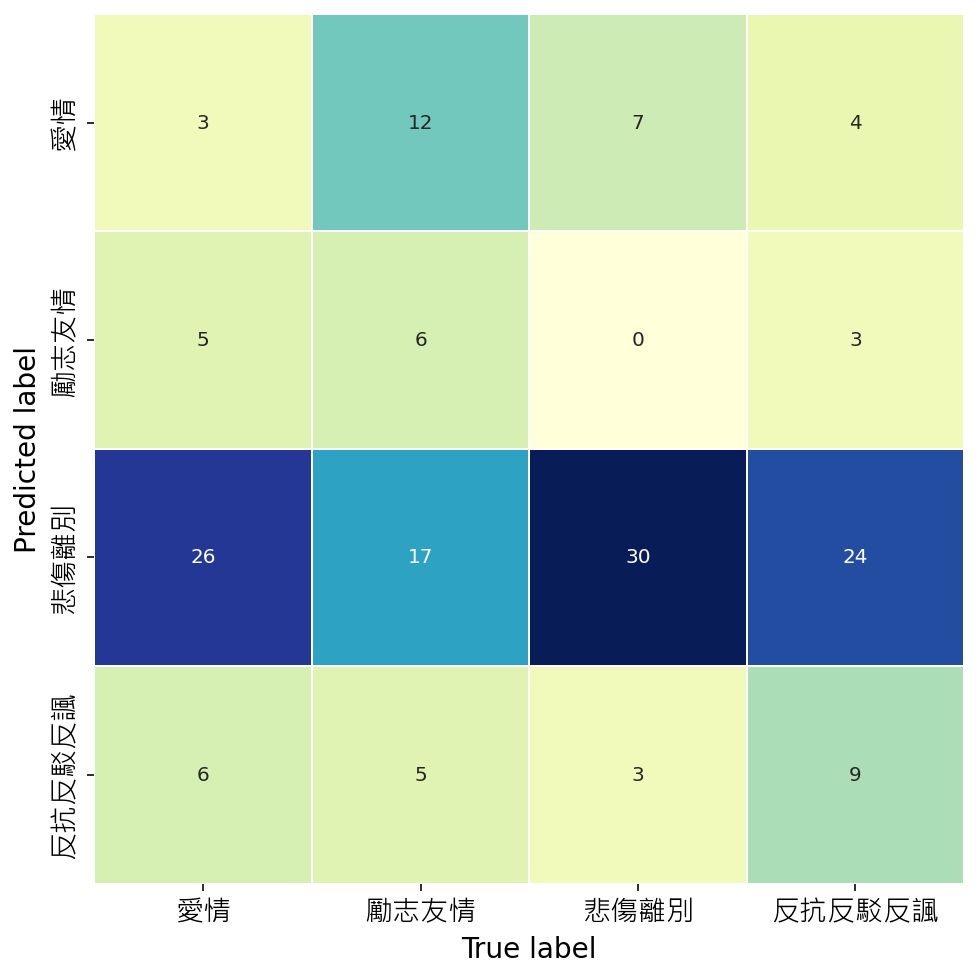

In [39]:
# plot confusion matrix
plt.figure(figsize = (8, 8))
sns.heatmap(confm.T, square = True, annot = True,
            fmt = 'd', cbar = False,linewidths = .8,
            cmap = "YlGnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.yticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.show()

## Bi-LSTM

In [40]:
test_loss, test_acc = model_BiLSTM.evaluate(test_seq_mat, test_y)
print('Test accuracy:', test_acc)
print("--------------------------------------------------------")
# test
test_pre = model_BiLSTM.predict(test_seq_mat)
# confusion matrix
confm = metrics.confusion_matrix(np.argmax(test_y, axis = 1),np.argmax(test_pre, axis = 1))
print(metrics.classification_report(np.argmax(test_y,axis=1),np.argmax(test_pre,axis=1), target_names=categories))

5/5 [==============================] - 1s 70ms/step - loss: 2.3122 - accuracy: 0.3688
Test accuracy: 0.3687500059604645
--------------------------------------------------------
              precision    recall  f1-score   support

          愛情       1.00      0.03      0.05        40
        勵志友情       0.56      0.25      0.34        40
        悲傷離別       0.34      0.85      0.49        40
      反抗反駁反諷       0.34      0.35      0.35        40

    accuracy                           0.37       160
   macro avg       0.56      0.37      0.31       160
weighted avg       0.56      0.37      0.31       160



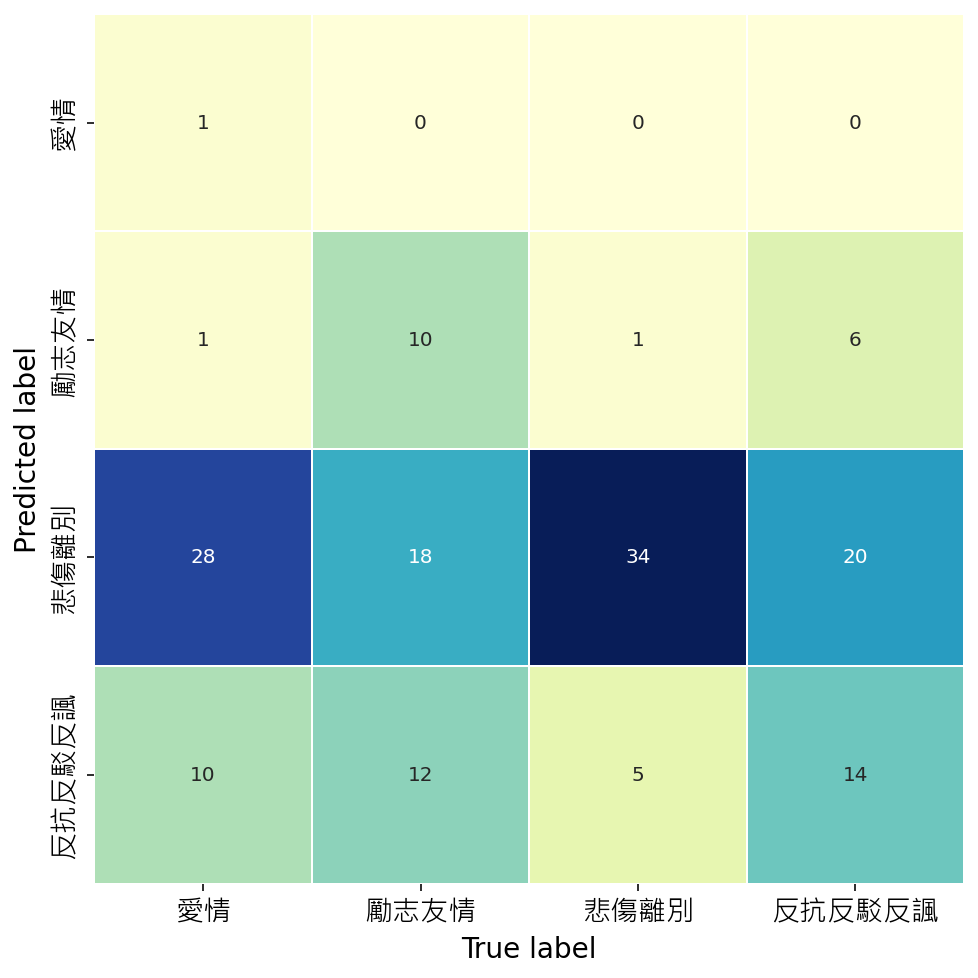

In [41]:
# plot confusion matrix
plt.figure(figsize = (8, 8))
sns.heatmap(confm.T, square = True, annot = True,
            fmt = 'd', cbar = False,linewidths = .8,
            cmap = "YlGnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.yticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.show()

## LSTM + Attention

In [42]:
test_loss, test_acc = model_LSTM_Att.evaluate(test_seq_mat, test_y)
print('Test accuracy:', test_acc)
print("--------------------------------------------------------")
# test
test_pre = model_LSTM_Att.predict(test_seq_mat)
# confusion matrix
confm = metrics.confusion_matrix(np.argmax(test_y, axis = 1),np.argmax(test_pre, axis = 1))
print(metrics.classification_report(np.argmax(test_y,axis=1),np.argmax(test_pre,axis=1), target_names=categories))

5/5 [==============================] - 1s 77ms/step - loss: 1.8371 - accuracy: 0.4062
Test accuracy: 0.40625
--------------------------------------------------------
              precision    recall  f1-score   support

          愛情       0.35      0.65      0.46        40
        勵志友情       0.40      0.57      0.47        40
        悲傷離別       0.14      0.03      0.04        40
      反抗反駁反諷       0.68      0.38      0.48        40

    accuracy                           0.41       160
   macro avg       0.39      0.41      0.36       160
weighted avg       0.39      0.41      0.36       160



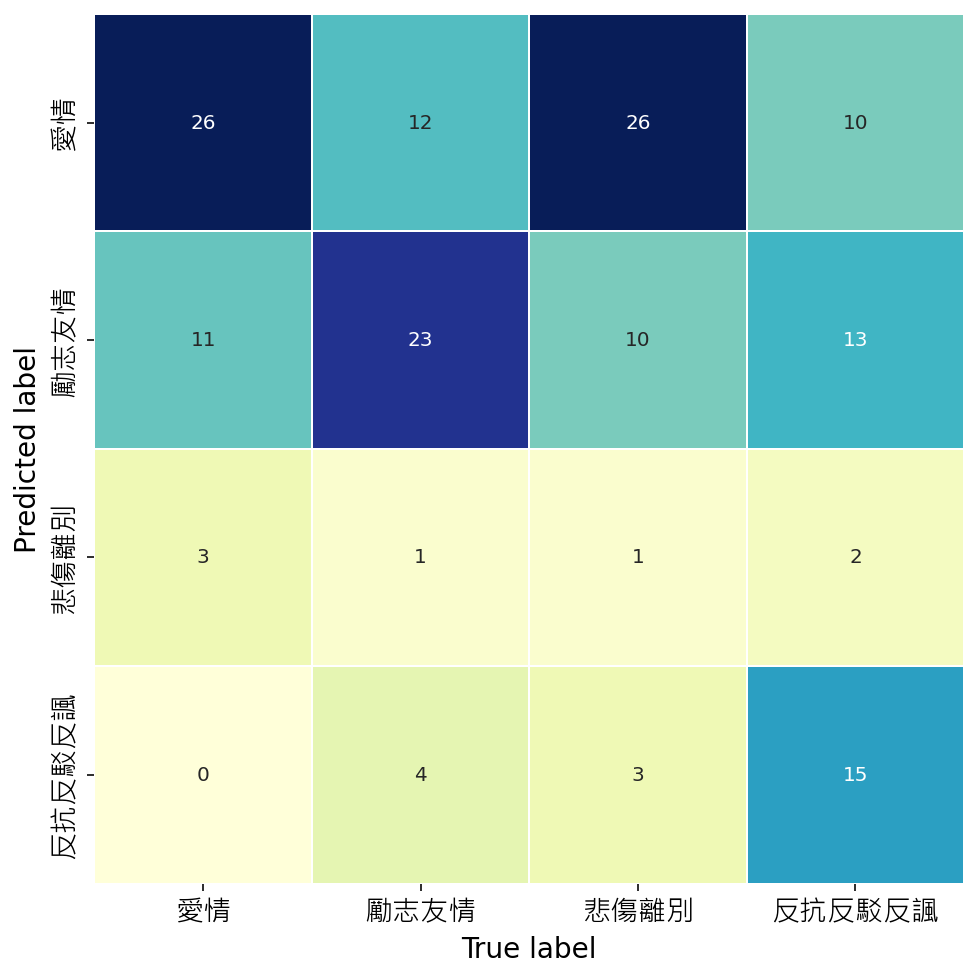

In [43]:
# plot confusion matrix
plt.figure(figsize = (8, 8))
sns.heatmap(confm.T, square = True, annot = True,
            fmt = 'd', cbar = False,linewidths = .8,
            cmap = "YlGnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.yticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.show()

## LSTM

In [44]:
test_loss, test_acc = model_LSTM.evaluate(test_seq_mat, test_y)
print('Test accuracy:', test_acc)
print("--------------------------------------------------------")
# test
test_pre = model_LSTM.predict(test_seq_mat)
# confusion matrix
confm = metrics.confusion_matrix(np.argmax(test_y, axis = 1),np.argmax(test_pre, axis = 1))
print(metrics.classification_report(np.argmax(test_y,axis=1),np.argmax(test_pre,axis=1), target_names=categories))

5/5 [==============================] - 1s 56ms/step - loss: 2.7145 - accuracy: 0.3938
Test accuracy: 0.39375001192092896
--------------------------------------------------------
              precision    recall  f1-score   support

          愛情       0.32      0.50      0.39        40
        勵志友情       0.50      0.30      0.37        40
        悲傷離別       0.36      0.55      0.44        40
      反抗反駁反諷       0.75      0.23      0.35        40

    accuracy                           0.39       160
   macro avg       0.48      0.39      0.39       160
weighted avg       0.48      0.39      0.39       160



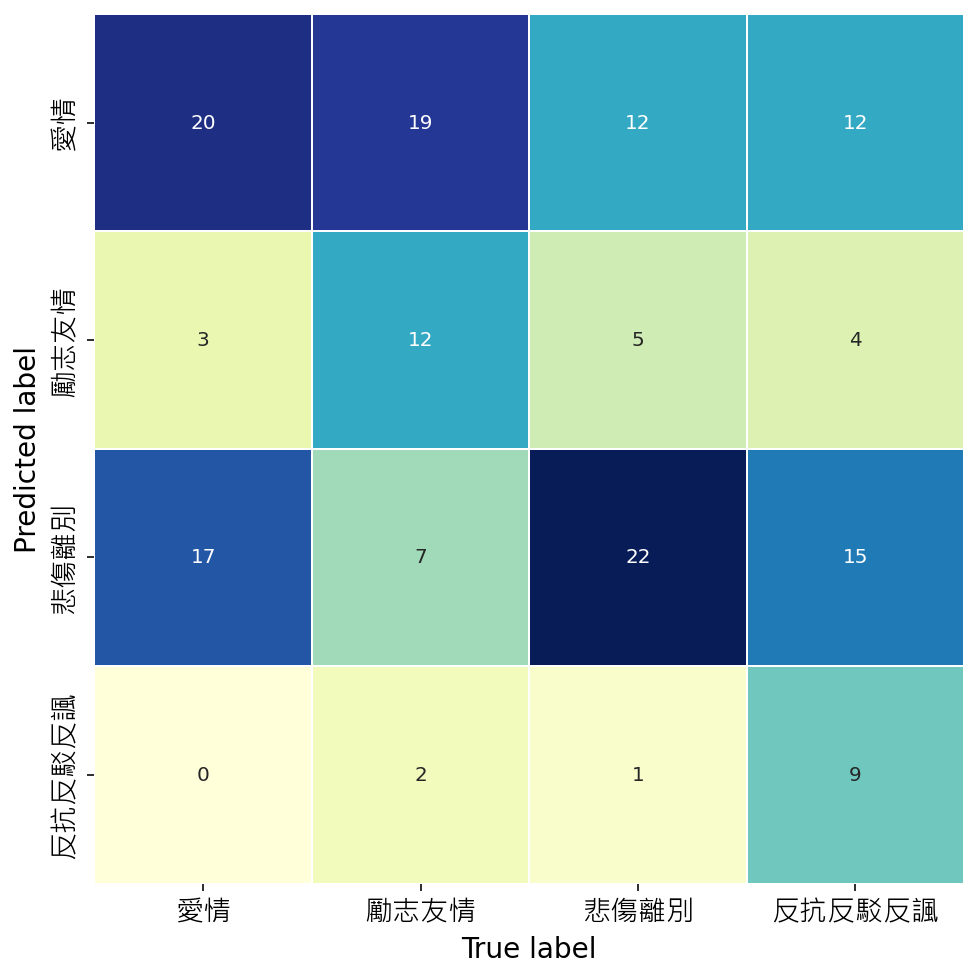

In [45]:
# plot confusion matrix
plt.figure(figsize = (8, 8))
sns.heatmap(confm.T, square = True, annot = True,
            fmt = 'd', cbar = False,linewidths = .8,
            cmap = "YlGnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.yticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.show()